<font size="+3"><center>
    MVPA analysis: SVM on cross-sampled conditions
</font></center>

Author:
Egor Ananyev

# Preparation

## Loading packages

In [1]:
%matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
import os

In [2]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [3]:
mne.set_log_level('warning')  # less verbose output

## Setting parameters

In [8]:
debug = False

cur_subj = 1
numof_runs = 7  # TEMP; is 7 for subj 01

## Loading evoked data

In [5]:
# data_path = os.path.expanduser("C:\\Users\\egora\\Downloads\\meg\\")
data_path = os.path.expanduser('E:\\meg\\')

cur_subj_str = str(cur_subj).zfill(2)

for cur_run in range(numof_runs):
    cur_run_str = str(cur_run+1).zfill(2)
    fname = os.path.join(data_path,
                             'derivatives\\meg_derivatives\\sub-' + cur_subj_str + '\\ses-meg\\meg\\sub-' + \
                             cur_subj_str + '_ses-meg_experimental_run-' + cur_run_str + '_proc-sss_300_epo.fif')
    print(fname)
    epochs_run = mne.read_epochs(fname)
    # example append: https://www.programcreek.com/python/example/92634/mne.Epochs
    epochs_run = epochs_run.pick_types(meg=True)
    epochs_run_df = epochs_run.to_data_frame()
    # Normalizing the signal by the baseline:
    epochs_run_std = epochs_run_df.sort_index(level=['condition', 'epoch', 'time'], ascending=[1, 1, 1])
    epochs_run_std = epochs_run_std.loc[pd.IndexSlice[:, :, -100:-1], :].groupby(['condition', 'epoch']).std()
    epochs_run_norm = epochs_run_df / epochs_run_std
    if cur_run == 0:
        epochs_df = epochs_run_norm
    else: 
        epochs_df = epochs_df.append(epochs_run_norm)

E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-01_proc-sss_300_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-02_proc-sss_300_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-03_proc-sss_300_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-04_proc-sss_300_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-05_proc-sss_300_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-06_proc-sss_300_epo.fif
E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg\sub-01_ses-meg_experimental_run-07_proc-sss_300_epo.fif


In [6]:
all_times = np.round(epochs_run.times * 1000).astype(int)
# print(all_times)
print(np.shape(all_times))

(211,)


The path to store MVPA-related data and visualization.

In [7]:
mvpa_path = os.path.join(data_path, 'derivatives\\meg_derivatives\\sub-' + cur_subj_str + '\\ses-meg\\meg-mvpa\\')
mvpa_fname = os.path.join(mvpa_path, 'sub-' + cur_subj_str)
print(mvpa_fname)

E:\meg\derivatives\meg_derivatives\sub-01\ses-meg\meg-mvpa\sub-01


# Support Vector Machines

## SVM routine

In [15]:
# This suppresses the sklearn warnings
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

In [47]:
def run_svm(X_, y_, conds_indx, test_cond, kernel_='sigmoid', n_iters=10, track=True):
    acc_list = []
    test_index = np.flatnonzero(np.core.defchararray.find(conds_indx.astype(str), test_cond)!=-1)
    train_index = np.flatnonzero(np.core.defchararray.find(conds_indx.astype(str), test_cond)==-1)
    X_train = X_[train_index]
    y_train = y_[train_index]
    X_test = X_[test_index]
    y_test = y_[test_index]
    for i in range(n_iters):
        clf = svm.SVC(C=0.1, kernel=kernel_, gamma=0.001, cache_size=2000).fit(X_train, y_train)
    #     clf = svm.SVR(cache_size=2000).fit(X_train, y_train)  # won't work with accuracy_score
    #     scores = cross_val_score(clf, X_train, y_train, cv=4)
    #     print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        y_pred = clf.predict(X_test)
    #     print(classification_report(y_test, y_pred))
        this_acc = accuracy_score(y_test, y_pred)
        acc_list.append(this_acc)
    #     print(accuracy_score(y_test, y_pred))
    if track:
        print('{0:.2f}'.format(np.mean(acc_list)), end=' ')
    return np.mean(acc_list), np.std(acc_list)

## Iterating through _t_

In [48]:
def iter_times(all_times_, epochs_subset_df_, test_cond, kernel='sigmoid', n_iters=10, track=True):  #, validate=False):
    acc_mean = []
    acc_sd = []
    counter = 0
    print('[', end=' ')
    for t in all_times_:
        if (counter == int(len(all_times)/10)):
            print('||', end=' ')
            counter = 0
        counter += 1
#         X_right = epochs_subset_df_.loc[('right/'+cur_cond_str_, slice(None), t), :].values
#         X_left = epochs_subset_df_.loc[('left/'+cur_cond_str_, slice(None), t), :].values
        X_right = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('right')].loc[pd.IndexSlice[:, :, t], :]
        X_left = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('left')].loc[pd.IndexSlice[:, :, t], :]
        X = np.concatenate((X_right, X_left))
        y = np.concatenate((np.repeat(1, len(X_right)), np.repeat(0, len(X_left))))
        conds_indx_right = X_right.index.get_level_values('condition')
        conds_indx_left = X_left.index.get_level_values('condition')
        conds_indx = np.concatenate((conds_indx_right, conds_indx_left))
        acc_this_mean, acc_this_sd = run_svm(X, y, conds_indx, test_cond, kernel_=kernel, n_iters=n_iters, track=track)
        acc_mean.append(acc_this_mean)
        acc_sd.append(acc_this_sd)
    print(']')
    return acc_mean, acc_sd

# Testing conditions separately

In [53]:
all_durs = [1, 2, 3, 4]
all_conts = [17, 33, 50, 100]
acc_index = pd.MultiIndex.from_product([all_durs, all_conts], names=['dur', 'cont'])
acc = pd.DataFrame(np.zeros((len(all_durs)*len(all_conts), len(all_times))), index=acc_index, columns=all_times)
acc_sd = pd.DataFrame(np.zeros((len(all_durs)*len(all_conts), len(all_times))), index=acc_index, columns=all_times)
for cur_dur in range(len(all_durs)):
    for cur_cont in range(len(all_conts)):
        cur_cond_str = 'dur' + str(all_durs[cur_dur]) + '/' + 'cont' + str(all_conts[cur_cont]).zfill(3)
        print(cur_cond_str, end=' ')
        cur_acc, cur_sd = iter_times(all_times, epochs_df, test_cond=cur_cond_str, n_iters=10, track=False)
        acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :] = cur_acc
        acc_sd.loc[(all_durs[cur_dur], all_conts[cur_cont]), :] = cur_sd

dur1/cont017 [ || || || || || || || || || || ]
dur1/cont033 [ || || || || || || || || || || ]
dur1/cont050 [ || || || || || || || || || || ]
dur1/cont100 [ || || || || || || || || || || ]
dur2/cont017 [ || || || || || || || || || || ]
dur2/cont033 [ || || || || || || || || || || ]
dur2/cont050 [ || || || || || || || || || || ]
dur2/cont100 [ || || || || || || || || || || ]
dur3/cont017 [ || || || || || || || || || || ]
dur3/cont033 [ || || || || || || || || || || ]
dur3/cont050 [ || || || || || || || || || || ]
dur3/cont100 [ || || || || || || || || || || ]
dur4/cont017 [ || || || || || || || || || || ]
dur4/cont033 [ || || || || || || || || || || ]
dur4/cont050 [ || || || || || || || || || || ]
dur4/cont100 [ || || || || || || || || || || ]


The standard errors from multiple iterations are all zeros, as expected if the same training / testing data sets are used with limited sample:

In [61]:
acc_sd.head()

-100          -97           -93   -90   -87           -83   \
dur cont                                                                       
1   17    0.000000e+00  0.000000e+00  0.000000e+00   0.0   0.0  0.000000e+00   
    33    5.551115e-17  5.551115e-17  0.000000e+00   0.0   0.0  0.000000e+00   
    50    1.110223e-16  0.000000e+00  5.551115e-17   0.0   0.0  5.551115e-17   
    100   5.551115e-17  0.000000e+00  0.000000e+00   0.0   0.0  0.000000e+00   
2   17    0.000000e+00  0.000000e+00  0.000000e+00   0.0   0.0  0.000000e+00   

          -80           -77   -73   -70   ...   570           573  \
dur cont                                  ...                       
1   17     0.0  0.000000e+00   0.0   0.0  ...   0.0  0.000000e+00   
    33     0.0  0.000000e+00   0.0   0.0  ...   0.0  0.000000e+00   
    50     0.0  0.000000e+00   0.0   0.0  ...   0.0  0.000000e+00   
    100    0.0  5.551115e-17   0.0   0.0  ...   0.0  1.110223e-16   
2   17     0.0  0.000000e+00   0.0   0.0  ...   0.0  0.000000e+00   

                   577           580           583           587   590  \
dur cont                                                                 
1   17    0.000000e+00  0.000000e+00  5.551115e-17  0.000000e+00   0.0   
    33    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.0   
    50    5.551115e-17  0.000000e+00  0.000000e+00  5.551115e-17   0.0   
    100   1.110223e-16  1.110223e-16  0.000000e+00  0.000000e+00   0.0   
2   17    0.000000e+00  0.000000e+00  0.000000e+00  5.551115e-17   0.0   

                   593           597           600  
dur cont                                            
1   17    5.551115e-17  5.551115e-17  5.551115e-17  
    33    0.000000e+00  0.000000e+00  0.000000e+00  
    50    5.551115e-17  0.000000e+00  5.551115e-17  
    100   1.110223e-16  1.110223e-16  1.110223e-16  
2   17    0.000000e+00  0.000000e+00  0.000000e+00  

[5 rows x 211 columns]

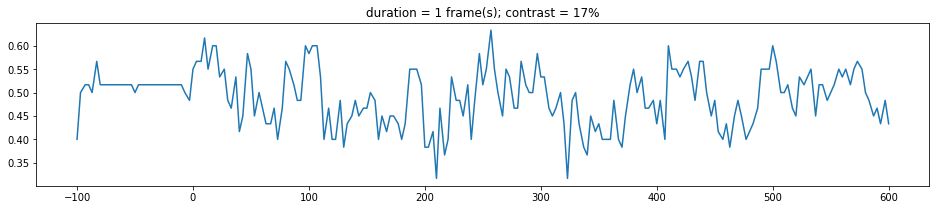

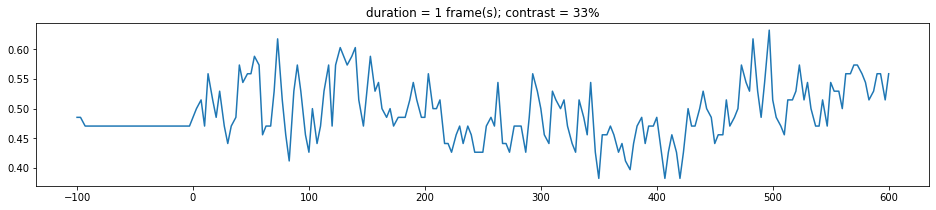

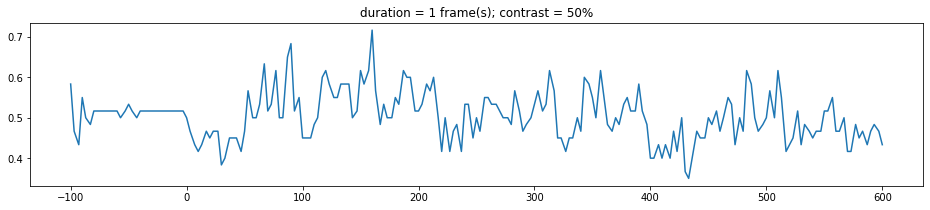

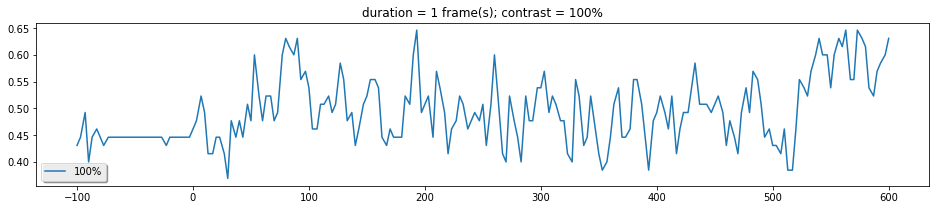

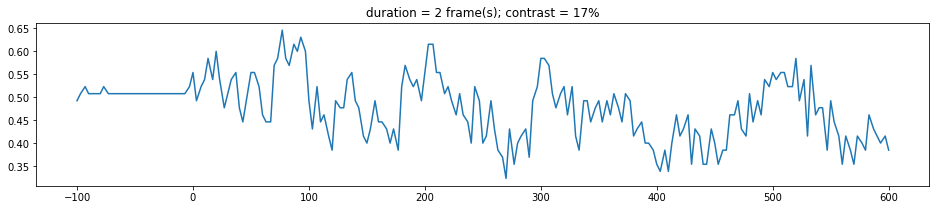

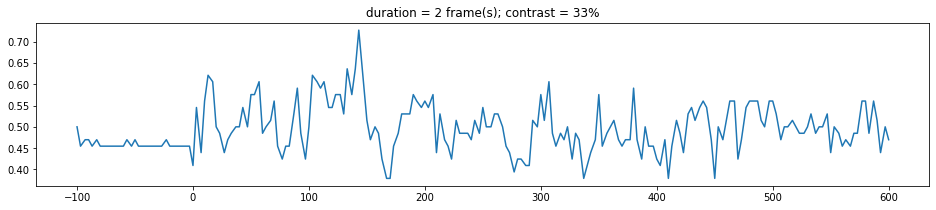

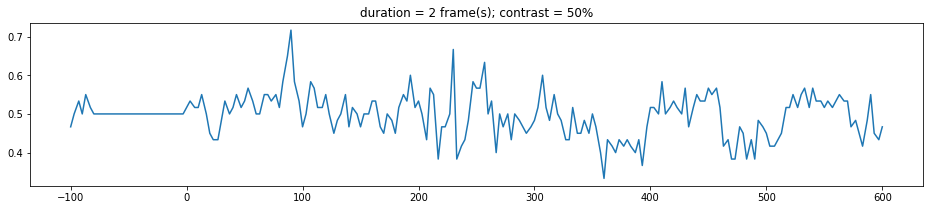

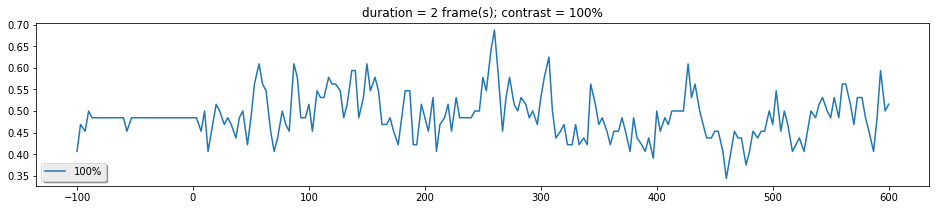

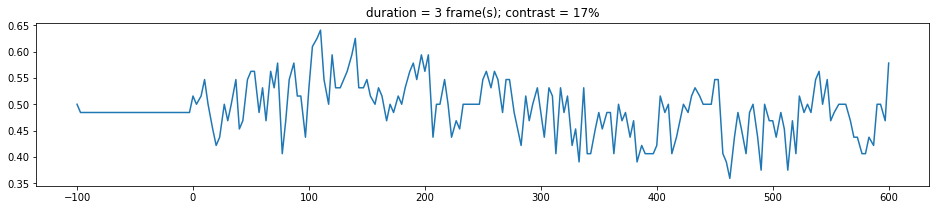

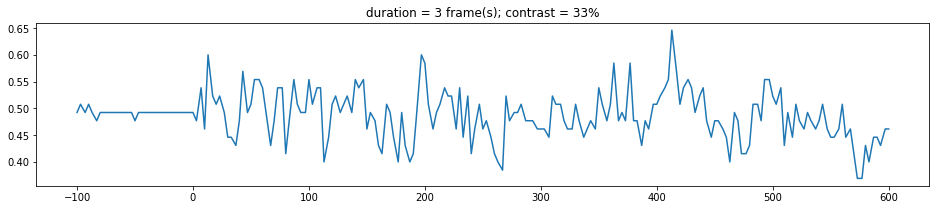

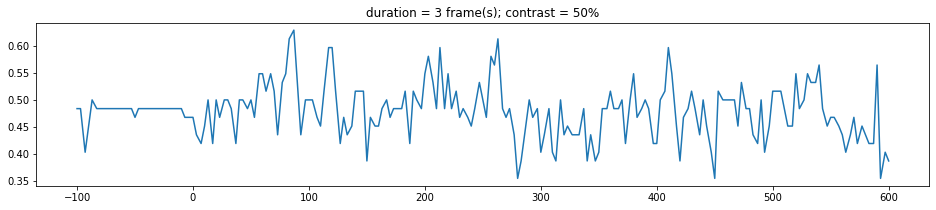

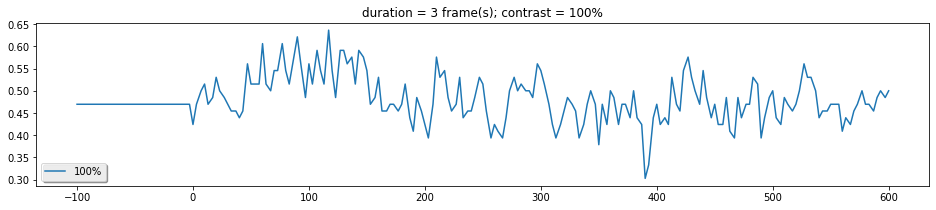

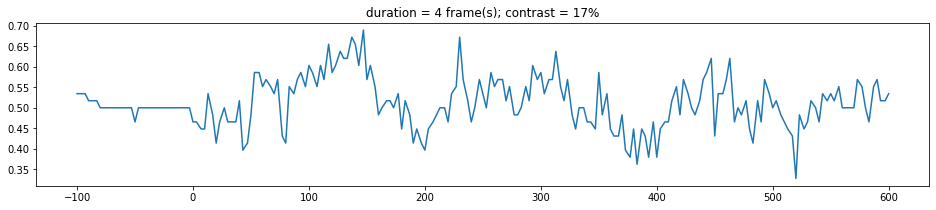

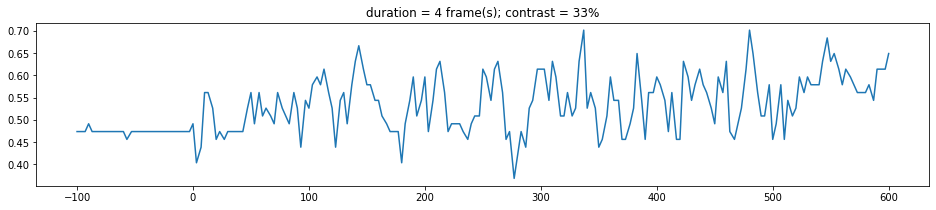

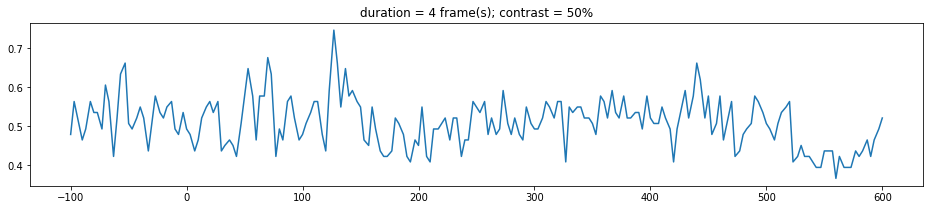

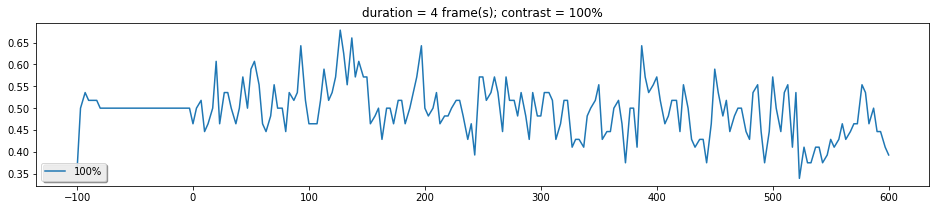

In [58]:
%matplotlib inline
for cur_dur in range(len(all_durs)):
#     plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frame(s)')
    for cur_cont in range(len(all_conts)):
        plt.figure(figsize=(16, 3))
        plt.title(label='duration = ' + str(all_durs[cur_dur]) + ' frame(s); contrast = ' + str(all_conts[cur_cont]) + '%')
        ## TODO: modify this code for plotting the error bars as well:
#         plt.errorbar(all_times, np.array(acc.T), yerr=acc_sd.to_numpy().flatten(), ecolor='gray', elinewidth=1)
#         plt.errorbar(all_times, np.array(acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :].T),
#                      yerr=acc_sd.loc[(all_durs[cur_dur], all_conts[cur_cont]), :].to_numpy().flatten(), ecolor='gray', elinewidth=1)
        plt.plot(all_times, np.array(acc.loc[(all_durs[cur_dur], all_conts[cur_cont]), :]).T, label = str(all_conts[cur_cont]) + '%');
        # plt.savefig(qc_fname + '_light-sensors.pdf')
    leg = plt.legend(loc='lower left', ncol=4, shadow=True, fancybox=True)
    leg.get_frame().set_alpha(0.8)

# Debug: Single-_t_ case

## Data set

In [9]:
all_durs = 4  # [1, 2, 3, 4]
all_conts = 100  # [17, 33, 50, 100]
t = 87
acc_index = pd.MultiIndex.from_product([[all_durs], [all_conts]], names=['dur', 'cont'])
acc = pd.DataFrame(np.zeros((1, len(all_times))), index=acc_index, columns=all_times)
cur_cond_str = 'dur4/cont100'
epochs_subset_df = epochs_df[epochs_df.index.get_level_values('condition').str.contains(cur_cond_str)].loc[pd.IndexSlice[:, :, t], :]

In [10]:
cur_cond_str

'dur4/cont100'

In [12]:
epochs_subset_df.head()

channel                         MEG0111   MEG0112   MEG0113   MEG0121  \
condition          epoch time                                           
left/dur4/cont100  28    87   -0.532187  0.841984 -1.148955  0.347068   
                   73    87    0.001669 -1.914992  0.199287 -1.372988   
                   95    87    0.681560 -0.563295  0.765399  0.715947   
                   126   87   -0.534997 -0.710329 -0.548943 -0.427726   
right/dur4/cont100 4     87   -2.445140 -1.466747 -0.095105 -0.385865   

channel                         MEG0122   MEG0123   MEG0131   MEG0132  \
condition          epoch time                                           
left/dur4/cont100  28    87   -1.579909 -3.290678 -0.391222 -0.317216   
                   73    87    3.170342 -1.952600 -1.374324  2.139605   
                   95    87    0.360059 -0.723701  0.236989  0.834155   
                   126   87    0.468687 -1.317231 -0.556383 -0.231864   
right/dur4/cont100 4     87   -3.366335 -2.008671 -1.841708 -0.641995   

channel                         MEG0133   MEG0141  ...   MEG2613   MEG2621  \
condition          epoch time                      ...                       
left/dur4/cont100  28    87   -0.196515 -0.286258  ...  1.044088  0.092528   
                   73    87    1.526470 -0.740860  ...  0.158870  0.046312   
                   95    87   -0.664150  0.887055  ...  0.494617  2.264427   
                   126   87    0.275846 -0.613895  ... -0.621866  0.477739   
right/dur4/cont100 4     87   -2.394797 -3.067721  ...  1.121475  0.685971   

channel                         MEG2622   MEG2623   MEG2631   MEG2632  \
condition          epoch time                                           
left/dur4/cont100  28    87    1.524620 -0.184261 -0.262131  1.135570   
                   73    87    1.000366  1.192295 -0.653409  1.266271   
                   95    87    0.405463  0.952683  1.904693  1.495239   
                   126   87    0.307991  0.025939  0.549352 -0.251330   
right/dur4/cont100 4     87    2.077424  0.828034 -0.204393  2.952911   

channel                         MEG2633   MEG2641   MEG2642   MEG2643  
condition          epoch time                                          
left/dur4/cont100  28    87    0.092440  0.130450 -1.165723  1.599685  
                   73    87    1.051696 -0.655872 -1.240132  0.427472  
                   95    87    1.414530  1.081656  1.069487  1.193491  
                   126   87   -0.384747  0.567895  0.259209  0.023715  
right/dur4/cont100 4     87    1.190045 -0.288802  0.150969  1.286949  

[5 rows x 306 columns]

In [28]:
# cur_acc = iter_times(all_times, epochs_subset_df, validate=False)  #, cur_cond_str)
# all_times = np.round(epochs_run.times * 1000).astype(int)
# epochs_subset_df_ = epochs_subset_df
# X_right = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('right')].loc[pd.IndexSlice[:, :, t], :]
# X_left = epochs_subset_df_[epochs_subset_df_.index.get_level_values('condition').str.contains('left')].loc[pd.IndexSlice[:, :, t], :]
X_right = epochs_df[epochs_df.index.get_level_values('condition').str.contains('right')].loc[pd.IndexSlice[:, :, t], :]
X_left = epochs_df[epochs_df.index.get_level_values('condition').str.contains('left')].loc[pd.IndexSlice[:, :, t], :]
X = np.concatenate((X_right, X_left))
y = np.concatenate((np.repeat(1, len(X_right)), np.repeat(0, len(X_left))))
conds_indx_right = X_right.index.get_level_values('condition')
conds_indx_left = X_left.index.get_level_values('condition')
conds_indx = np.concatenate((conds_indx_right, conds_indx_left))
print(conds_indx)

['right/dur1/cont017' 'right/dur1/cont017' 'right/dur1/cont017' ...
 'left/dur4/cont100' 'left/dur4/cont100' 'left/dur4/cont100']


In [46]:
test_cond = cur_cond_str
print(conds_indx)
print(test_cond)
# np.find(conds_indx, test_cond)
# [i for i, item in enumerate(conds_indx) if test_cond in item]
# np.core.defchararray.find(conds_indx.astype(str), ['dur4/cont100'])
print(np.flatnonzero(np.core.defchararray.find(conds_indx.astype(str), ['dur4/cont100'])!=-1))
print(np.flatnonzero(np.core.defchararray.find(conds_indx.astype(str), ['dur4/cont100'])==-1))

['right/dur1/cont017' 'right/dur1/cont017' 'right/dur1/cont017' ...
 'left/dur4/cont100' 'left/dur4/cont100' 'left/dur4/cont100']
dur4/cont100
[  71   72  142  143  144  145  213  214  215  216  217  282  283  284
  285  286  354  355  356  357  358  433  434  435  501  502  503  504
  572  573  574  575  644  645  646  647  716  717  718  789  790  791
  792  858  859  860  861  862  863  930  931  932 1003 1004 1005 1006]
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   73   74   75   76   77   78   79   80   81   82   83   84   85
   86   87   88   89   90   91   92   93   94   95   96   97   98   99
  100  101  102  103  104  105  106  107  108  109  110  111  112  113
  11

In [14]:
X

array([[-1.02365007, -1.55588675,  0.97907058, ...,  0.95425321,
        -1.81877869,  0.31250099],
       [-0.65719249, -1.8822684 ,  0.09203422, ..., -0.34739062,
         0.02903462,  0.67668067],
       [-0.02227319,  0.12699574, -0.97254488, ...,  0.79429244,
        -0.30491273, -1.65491967],
       ...,
       [ 3.47013345,  0.7284099 ,  2.96249864, ..., -2.3010024 ,
        -3.85794519, -0.14223711],
       [-1.57812382, -2.54074348,  2.41419373, ...,  2.40113169,
        -4.18864063,  1.94199472],
       [ 1.68009904,  1.87498637,  0.74524303, ...,  2.68492384,
        -2.30447801, -2.37801348]])

In [15]:
np.shape(X)

(1007, 306)

## Processing

In [55]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [56]:
# clf = svm.SVC(kernel='sigmoid')
# scores = cross_val_score(clf, X, y, cv=4)

In [57]:
# scores

In [58]:
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [17]:
ss = ShuffleSplit(n_splits=1, test_size=0.2)

In [22]:
for train_index, test_index in ss.split(X):
#     print("%s %s" % (train_index, test_index))
#     print("%s %s" % (len(train_index), len(test_index)))
    print(train_index)
    print(test_index)
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
#     clf = svm.SVC(kernel='sigmoid', gamma=0.001, cache_size=2000).fit(X_train, y_train)
##     clf = svm.SVR(cache_size=2000).fit(X_train, y_train)  # won't work with accuracy_score
##     scores = cross_val_score(clf, X_train, y_train, cv=4)
##     print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
#     y_pred = clf.predict(X_test)
##     print(classification_report(y_test, y_pred))
#     this_acc = accuracy_score(y_test, y_pred)
#     acc_list.append(this_acc)
##     print(accuracy_score(y_test, y_pred))
# print(np.mean(acc_list))

[ 334  330  422  612  822  767   48  211  154  384  698 1006  843  816
   20  947  499  688  288  102  973  225  998   82  979  993  919  412
   52  817  142  466  842   12  835  856  347  490  543  810  659  502
  175  525  105  114  956  126   65  432  446  617  554  258  937  444
  884  121  727  896  298   16  111  916  849  630  489  294  144  442
  796   15   21  366  561  339  356  635   42  818  467  407  156  282
  116  185  633  168  146    3  674    7  138  457   46  253  376  639
  313  199  736  355  171  906  859  753  893  145  952  708  791  385
    6  714  463  870  687  364  354   64  832  866  187  701  479  336
  833   77  803  795   11  415  992  530  681   90  451  325  592  428
  903  583  470  966   31   83   19  508  725  868  958  772  939  936
  140  941  572  136  571  829  844  933  794  469  743  967   99   91
  130  773  477  197  886  426   63   27  202  133  269  710  711  196
  811  361  755  608  962   35  172  338  603  104  934  643    8  352
  246 

In [63]:
clf.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 2000,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.001,
 'kernel': 'sigmoid',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [43]:
np.mean(acc_list)

0.5042857142857143